In [1]:
import numpy as np
import nrlib
import matplotlib.pyplot as plt
np.random.seed(123)
%matplotlib inline

In [126]:
def corr_to_filter(ccc, LLL, XXX):
    dx = LLL/XXX.size
    return np.real(np.fft.ifft(np.sqrt(np.fft.fft(ccc) * dx)) / dx )

#### Import and utilities end

In [131]:
v = nrlib.variogram('gaussian', 1.0)

In [164]:
L = 4.0
X = np.linspace(0, L, 101)
f_sq = [v.corr(L/2 - x) for x in X]
f = np.sqrt(np.array(f_sq))

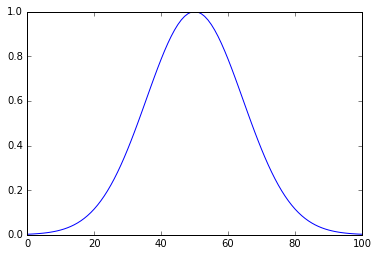

In [165]:
plt.plot(f)

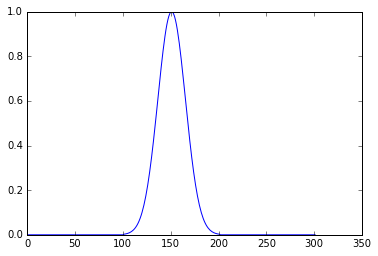

In [166]:
w_spike = np.zeros((X.size * 2,))
w_spike[X.size] = 1.0
plt.plot(np.convolve(w_spike, f))

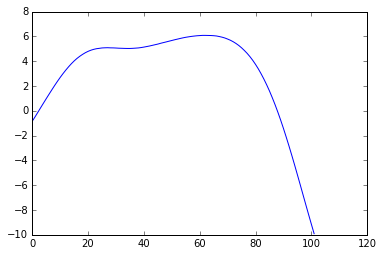

In [167]:
w = np.random.normal(size=(X.size * 2,))
plt.plot(np.convolve(w, f, 'valid'))

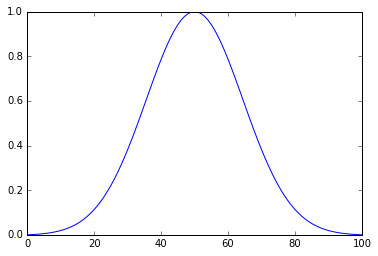

In [168]:
f2 = (f - np.min(f))
f2 = f2/np.max(f2)
plt.plot(f2)

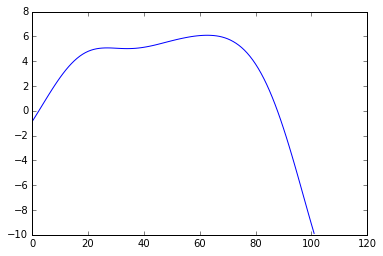

In [169]:
plt.plot(np.convolve(w, f2, 'valid'))

In [170]:
f3 = f * np.exp(-np.square((X-np.max(X)/2.0)*2))

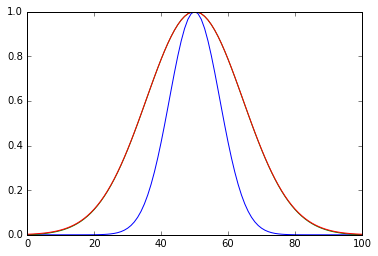

In [171]:
plt.plot(f3)
plt.plot(f2)
plt.plot(f)

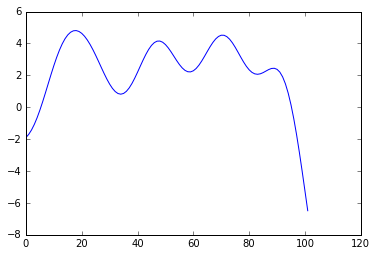

In [172]:
plt.plot(np.convolve(w, f3, 'valid'))

# Range

In [223]:
import scipy.optimize as so
from collections import OrderedDict

In [248]:
# Test variables
vtypes = ['spherical', 'exponential', 'general_exponential', 'gaussian', 'matern32', 'matern52']
powers = [1.5, 1.75, 1.99]
alpha = 0.05
effective_ranges = OrderedDict()

# Utility
def report_root(vtype, root):
    effective_ranges[vtype] = root
    print('{:30} {:.3f}'.format(vtype, root))

def f_root(v, alpha):
    return lambda x: v.corr(x) - alpha

# Experiment
for vtype in vtypes:
    if vtype == 'general_exponential':
        for p in powers:
            v = nrlib.variogram(vtype, 1.0, power=p)
            root = so.brentq(lambda x: v.corr(x) - alpha, 0.0, 10.0)
            report_root(vtype + ' - ' +str(p), root)
    else:
        v = nrlib.variogram(vtype, 1.0)
        root = so.brentq(lambda x: v.corr(x) - alpha, 0.0, 10.0)
        report_root(vtype, root)

spherical                      0.811
exponential                    0.999
general_exponential - 1.5      0.999
general_exponential - 1.75     0.999
general_exponential - 1.99     0.999
gaussian                       0.999
matern32                       1.000
matern52                       1.000


In [237]:
vtype = 'gaussian'
v = nrlib.variogram(vtype, 1.0, power=1.5)

L = effective_ranges[vtype] * 2
X = np.linspace(0, L, 101)
f_sq = [v.corr(L/2 - x) for x in X]
f = np.sqrt(np.array(f_sq))

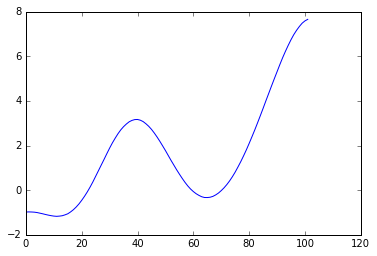

In [238]:
np.random.seed(121)
w = np.random.normal(size=(X.size * 2,))
plt.plot(np.convolve(w, f, 'valid'))

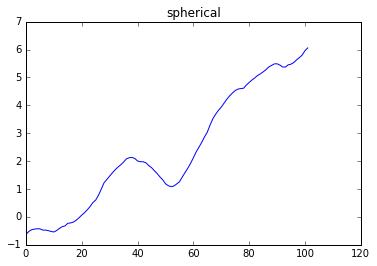

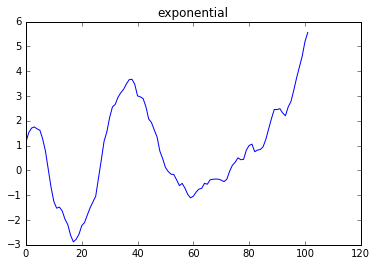

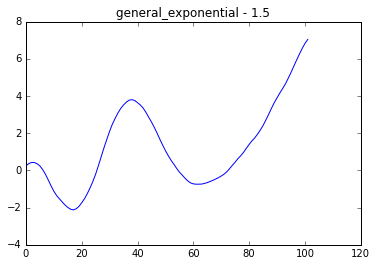

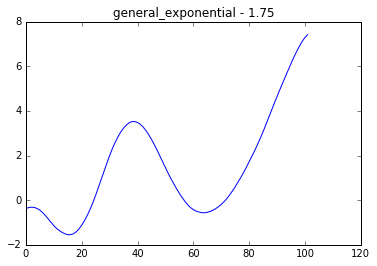

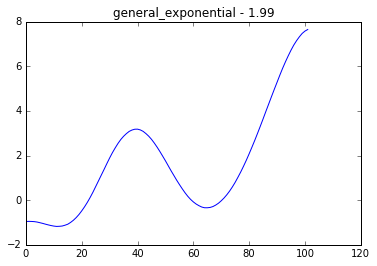

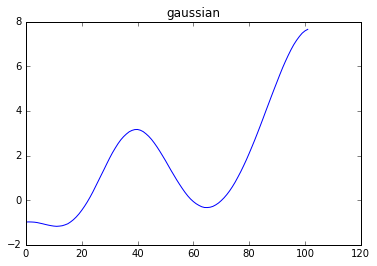

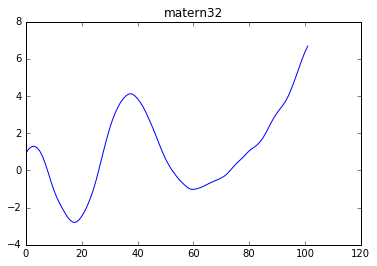

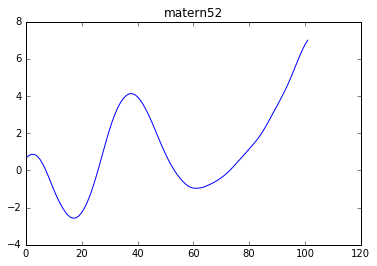

In [239]:
np.random.seed(121)
w = np.random.normal(size=(X.size * 2,))
for vtype in effective_ranges.keys():
    plt.title(vtype)
    L = effective_ranges[vtype] * 2
    X = np.linspace(0, L, 101)
    power = '1.0'
    if 'general' in vtype:
        vtype, power = vtype.split(' - ')
    v = nrlib.variogram(vtype, 1.0, power=float(power))
    f_sq = [v.corr(L/2 - x) for x in X]
    f = np.sqrt(np.array(f_sq))
    plt.plot(np.convolve(w, f, 'valid'))
    plt.show()
    

#### Foreløpig konklusjon:
Utfordringen ligger i at konvolusjonen egentlig ikke lar seg gjør på et for lite grid. Dette har ingenting med FFT å gjøre, men konvolusjonen i utgangspunktet.

Dette betyr at løsningen må enten:
- Lage griddet større
- Modifisere variogrammet
- ...

# Wrapping

FFT wrapper rundt. Det har innvirkning. Må sørge for at det tilfeldige feltet wrapper rundt, eller så er ikke dette en rettferdig sammenligning.

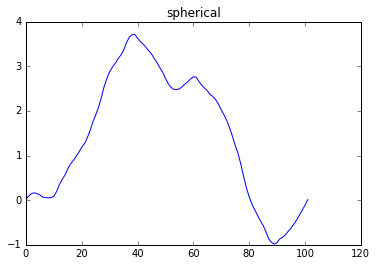

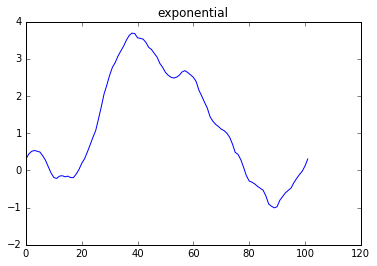

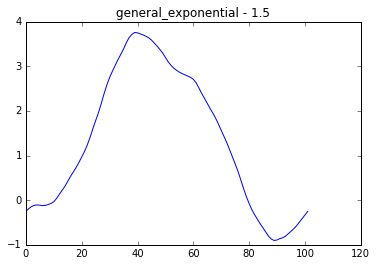

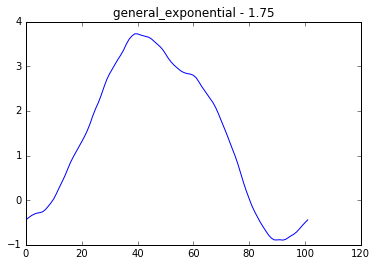

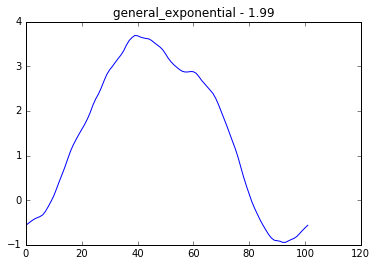

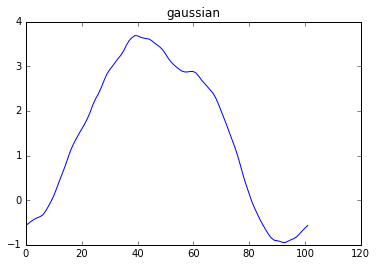

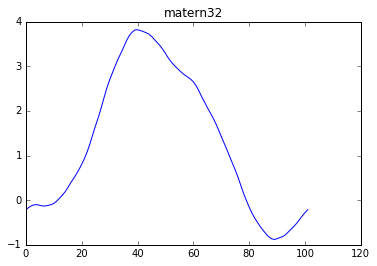

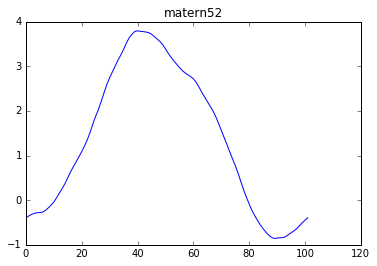

In [249]:
np.random.seed(121)
w = np.random.normal(size=(X.size,))
w = np.hstack((w, w))
for vtype in effective_ranges.keys():
    plt.title(vtype)
    L = effective_ranges[vtype] * 2
    X = np.linspace(0, L, 101)
    power = '1.0'
    if 'general' in vtype:
        vtype, power = vtype.split(' - ')
    v = nrlib.variogram(vtype, 1.0, power=float(power))
    f_sq = [v.corr(L/2 - x) for x in X]
    f = np.sqrt(np.array(f_sq))
    plt.plot(np.convolve(w, f, 'valid'))
    plt.show()
    

# Take two

Define the problem and plot the correlation kernel

In [208]:
v = nrlib.variogram('gaussian', 1.0)
L = 8.0
X = np.linspace(0, L, 1025)
c_list = [v.corr(L/2 - x) for x in X]
# c_list = [max(v.corr(L - x), v.corr(x)) for x in X]
c = np.array(c_list)

0.0

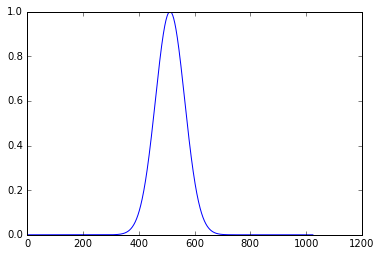

In [210]:
%matplotlib inline
plt.plot(c)
np.max(np.abs(c[::-1] - c))  # Print this to verify c is symmetric

For the Gaussian variogram, we have a closed for expression for a function that satisfies $f* f = c$. To verify that this function $f$ actually does satisfy this equality, we plot the convolution of the function with itself.

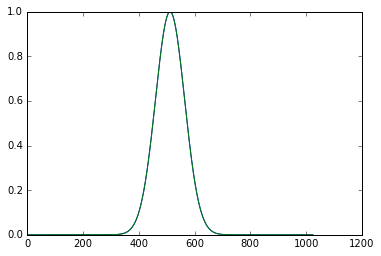

In [211]:
# Option A:
f = np.sqrt(np.sqrt(12/np.pi)) * np.exp(-6 * np.square(L/2 - X))

plt.plot(c)
ff_conv = L/X.size * np.convolve(
    np.pad(f, (int(X.size/2), int(X.size/2)), mode='constant', constant_values=0.0),
    f,
    'valid'
)
plt.plot(ff_conv)
plt.show()

We may compare this function to the correlation function

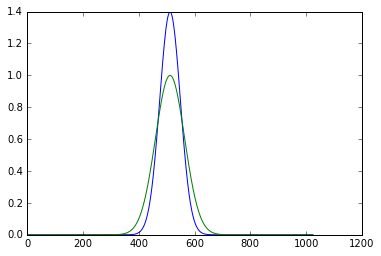

In [212]:
plt.plot(f)
plt.plot(c)

Further, the Fourier transform of the self-convolution of $f$ should be the same as the convolution of $c$.

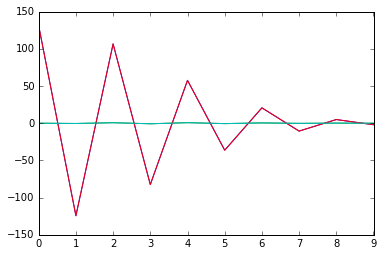

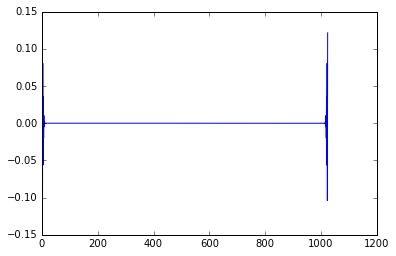

In [213]:
imax = 10
plt.plot(np.real(np.fft.fft(ff_conv))[:imax])
plt.plot(np.imag(np.fft.fft(ff_conv))[:imax])
plt.plot(np.real(np.fft.fft(c))[:imax])
plt.plot(np.imag(np.fft.fft(c))[:imax])
plt.show()
plt.plot(np.real(np.fft.fft(ff_conv)) - np.real(np.fft.fft(c)))
plt.show()

Alternatively, the FFT of convolution can be calculated by taking the FFT (DFT) of $f$ and multiplying this with itself. This should compare nicely to the FFT of the correlation function, $c$.

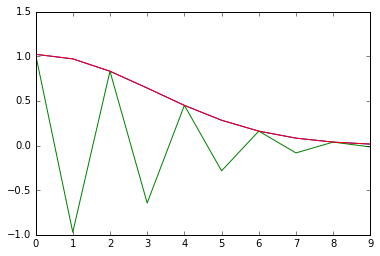

In [173]:
imax = 10
ff_conv_fft = np.fft.fft(f) * np.fft.fft(f) * (L/X.size) * (L/X.size)
c_conv_fft = np.fft.fft(c) * (L/X.size)
plt.plot(np.real(ff_conv_fft)[:imax])
plt.plot(np.real(c_conv_fft)[:imax])
plt.plot(np.abs(np.real(c_conv_fft)[:imax]))
# plt.plot(np.imag(ff_conv_fft)[:imax])
# plt.plot(np.imag(np.fft.fft(c))[:imax])
plt.show()
# plt.plot(np.real(np.fft.fft(ff_conv)) - np.real(np.fft.fft(c)))
# plt.show()

The sign here is different, but the absolute values match. This is probably related to the fact that the function $f$ is just one of the possible solutions to $f* f = c$?

Further, we may show the difference in using the explicit solution $f$, and the solution found by taking the positive square root of the correlation function in the FFT domain. This is not equivalent since the filters that are effectively used, are different

C:\Program Files\ROXAR\RMS 10.0.0\windows-amd64-vc_11_0-release\bin\lib\site-packages\numpy\core\numeric.py:474: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


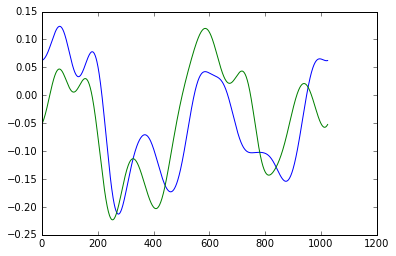

In [214]:
np.random.seed(123)
w = np.fft.fft(np.random.normal(size=c.shape))
plt.plot(
    np.fft.ifft(np.fft.fft(f) * L/X.size * w)
)
plt.plot(
    np.fft.ifft(np.sqrt(np.fft.fft(c) * L/X.size) * w)
)

Both simulations behave similarly (similar curvature, max/min values, etc.), but they are not equal. We therefore investigate the filter that is being apploed in the second case.

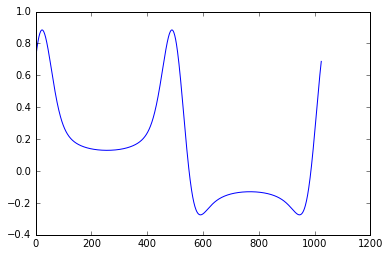

In [217]:
f2_fft = np.sqrt(np.fft.fft(c) * L/X.size)
f2 = np.real(np.fft.ifft(f2_fft) * X.size/L)

plt.plot(f2)

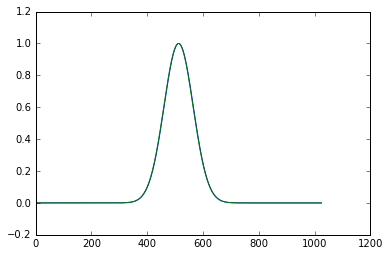

In [218]:
f2_double = np.hstack((f2, f2))

f2_conv = np.convolve(f2_double, f2, 'valid') * L/X.size

plt.plot(f2_conv)
plt.plot(c)

As we can see, this filter also satisfy $f * f = c$, which was intended by construction, but a double verification now proves its validity. Also, comparing the second filter with the explicit one shows two quite different filters.

# Investigating the filter for longer ranges

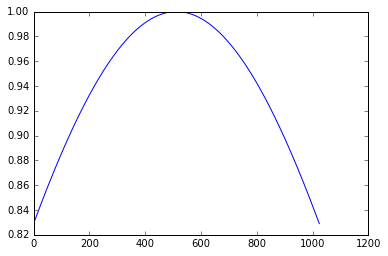

In [246]:
v = nrlib.variogram('gaussian', 1.0)
L = 0.5
X = np.linspace(0, L, 1025)
c_list = [v.corr(L/2 - x) for x in X]
# c_list = [max(v.corr(L - x), v.corr(x)) for x in X]
c = np.array(c_list)

plt.plot(c)

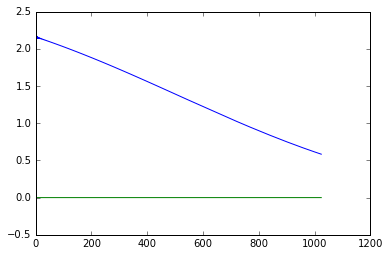

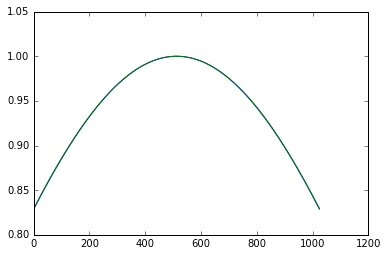

In [247]:
f = np.fft.ifft(np.sqrt(np.fft.fft(c) * L/X.size)) * X.size/L

plt.plot(np.real(f))
plt.plot(np.imag(f))
plt.show()

f_double = np.real(np.hstack((f, f)))
f_conv = np.convolve(f_double, np.real(f), 'valid') * L/X.size
plt.plot(f_conv)
plt.plot(c)
plt.show()

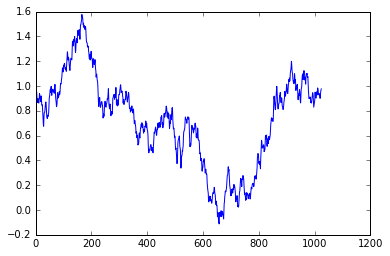

In [276]:
w_nrlib = nrlib.advanced.simulate(v, X.size, L/X.size, padx=0)
plt.plot(w_nrlib)

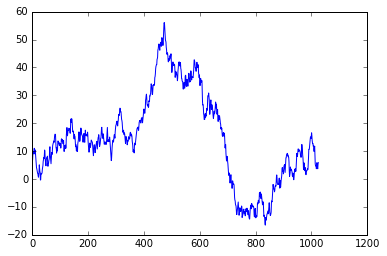

In [277]:
w = np.random.normal(size=(len(w_nrlib),))
w_double = np.hstack((w, w))
plt.plot(np.convolve(w_double, np.real(f), 'valid'))

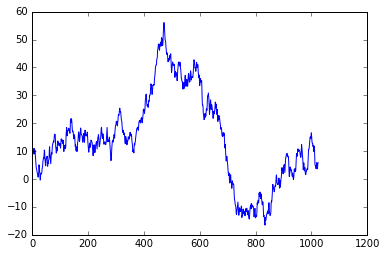

In [278]:
# Not to scale
plt.plot(
    np.real(np.fft.ifft(np.fft.fft(w) * np.fft.fft(f)))
)

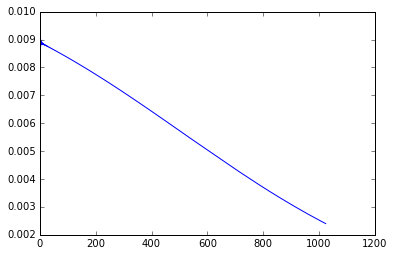

In [271]:
# Not to scale
dx = L/X.size
plt.plot(
    np.real(
        np.fft.ifft(np.fft.fft(w/w.size) * np.sqrt(np.fft.fft(c)))
    )
)

In [275]:
w_nrlib

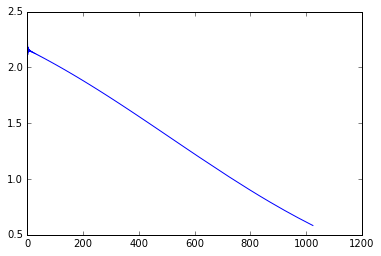

In [283]:
plt.plot(np.real(f))

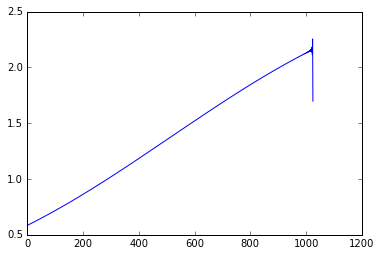

In [284]:
plt.plot(np.real(f[::-1]))

In [321]:
signs = (np.random.normal(size=c.shape) > 3.0)*2-1
signs = (np.arange(0, c.size) % 2) * 2 -1 

In [323]:
f_mod = np.fft.ifft(signs * np.sqrt(np.fft.fft(c) * L/X.size)) * X.size/L

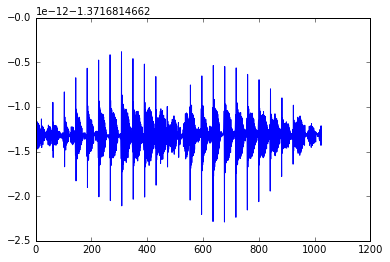

In [324]:
plt.plot(np.real(f_mod))

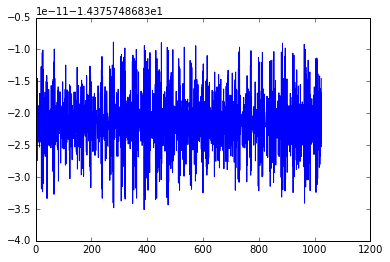

In [325]:
# Not to scale
plt.plot(
    np.real(np.fft.ifft(np.fft.fft(w) * np.fft.fft(f_mod)))
)

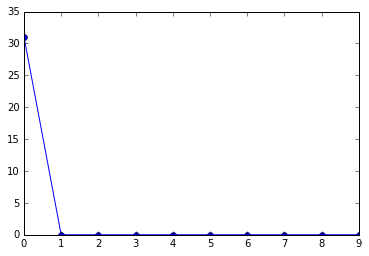

In [334]:
plt.plot(np.real(np.sqrt(np.fft.fft(c)))[:10], 'o-')

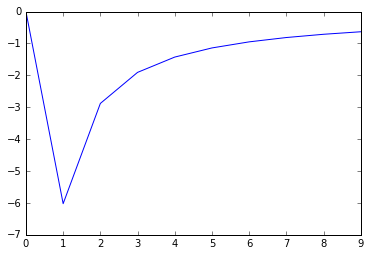

In [337]:
plt.plot(np.imag(np.sqrt(np.fft.fft(c)))[:10])

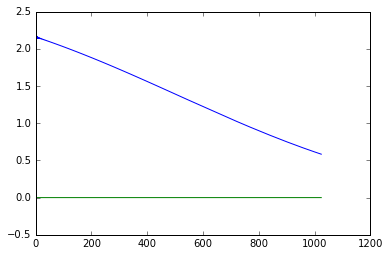

In [339]:
plt.plot(np.real(f))
plt.plot(np.imag(f))

# Finding the appropriate range thresholds

This section assumes that for a given range, the filter becomes circular continuous. Until this range is reached, we have a degenerate case for the transformation of $w$ (at least for the default filter choice). The solution to this problem is probably to find a different filter function that satisfy $f* f = c$, but this is not covered in this section. One solution that may be investigated in the Gaussian case is to use an analytically calculated filter.

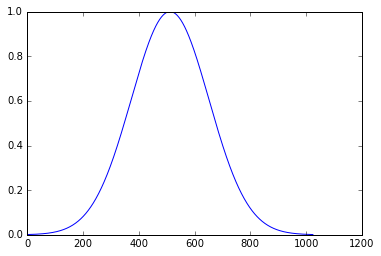

In [349]:
v = nrlib.variogram('gaussian', 1.0)
L = 3
X = np.linspace(0, L, 1025)
c_list = [v.corr(L/2 - x) for x in X]
c = np.array(c_list)
plt.plot(c)

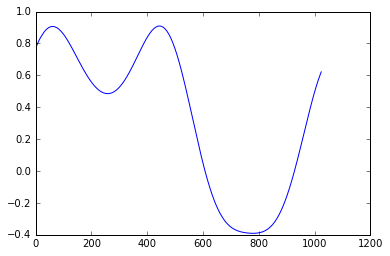

In [350]:
f = np.fft.ifft(np.sqrt(np.fft.fft(c) * L/X.size)) * X.size/L
plt.plot(np.real(f))

In [389]:
def analyze_filter_circ_diff(vtype, r, Lmax):
    v = nrlib.variogram(vtype, r)
    lvals = np.arange(0.1, 1.0, 0.05) * Lmax
    circ_diffs = []
    print('L        mean0   mean1   circdiff')
    for L in lvals:
        X = np.linspace(0, L, 1025)
        c_list = [v.corr(L/2 - x) for x in X]
        c = np.array(c_list)
        f = np.fft.ifft(np.sqrt(np.fft.fft(c) * L/X.size)) * X.size/L
        abs_diffs = np.abs(np.diff(np.real(f)))
        print('L={:.2f}   {:.4f}  {:.4f}  {:.4f}'.format(L, np.mean(abs_diffs[:100]), np.mean(abs_diffs[-100:]), np.abs(f[0]-f[-1])))
        circ_diffs.append(np.abs(f[0]-f[-1]))
    return lvals, circ_diffs

#### Gaussian

L        mean0   mean1   circdiff
L=1.00   0.0114  0.0007  1.1902
L=1.50   0.0086  0.0002  0.9119
L=2.00   0.0054  0.0017  0.5454
L=2.50   0.0029  0.0042  0.2640
L=3.00   0.0024  0.0065  0.1064
L=3.50   0.0028  0.0079  0.0387
L=4.00   0.0035  0.0087  0.0161
L=4.50   0.0042  0.0092  0.0105
L=5.00   0.0049  0.0095  0.0100
L=5.50   0.0055  0.0097  0.0107
L=6.00   0.0061  0.0097  0.0116
L=6.50   0.0067  0.0097  0.0125
L=7.00   0.0071  0.0097  0.0135
L=7.50   0.0075  0.0098  0.0144
L=8.00   0.0078  0.0099  0.0154
L=8.50   0.0081  0.0100  0.0163
L=9.00   0.0083  0.0101  0.0173
L=9.50   0.0085  0.0102  0.0182


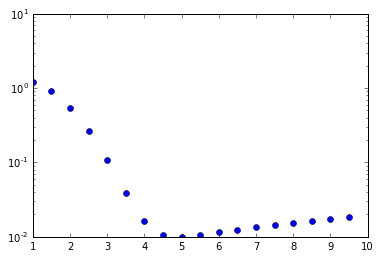

In [390]:
lvals, circ_diffs = analyze_filter_circ_diff('gaussian', 1.0, 10.0)
plt.semilogy(lvals, circ_diffs, 'o')

L        mean0   mean1   circdiff
L=2.00   0.0080  0.0005  0.8416
L=3.00   0.0061  0.0001  0.6448
L=4.00   0.0039  0.0012  0.3856
L=5.00   0.0021  0.0030  0.1867
L=6.00   0.0017  0.0046  0.0752
L=7.00   0.0020  0.0056  0.0274
L=8.00   0.0025  0.0061  0.0114
L=9.00   0.0030  0.0065  0.0074
L=10.00   0.0035  0.0067  0.0071
L=11.00   0.0039  0.0068  0.0076
L=12.00   0.0043  0.0069  0.0082
L=13.00   0.0047  0.0069  0.0089
L=14.00   0.0050  0.0069  0.0095
L=15.00   0.0053  0.0069  0.0102
L=16.00   0.0055  0.0070  0.0109
L=17.00   0.0057  0.0071  0.0115
L=18.00   0.0059  0.0072  0.0122
L=19.00   0.0060  0.0072  0.0129


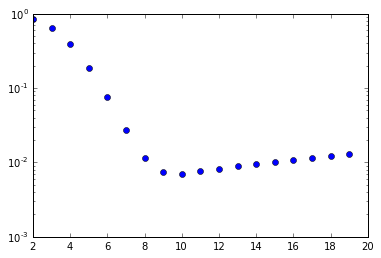

In [391]:
lvals, circ_diffs = analyze_filter_circ_diff('gaussian', 2.0, 20.0)
plt.semilogy(lvals, circ_diffs, 'o')

#### Spherical

L        mean0   mean1   circdiff
L=0.25   0.0013  0.0012  1.2250
L=0.38   0.0021  0.0020  1.2243
L=0.50   0.0030  0.0029  1.2230
L=0.63   0.0039  0.0037  1.2209
L=0.75   0.0048  0.0046  1.2178
L=0.88   0.0058  0.0055  1.2137
L=1.00   0.0067  0.0064  1.2085
L=1.13   0.0077  0.0073  1.2019
L=1.25   0.0087  0.0082  1.1938
L=1.38   0.0097  0.0091  1.1841
L=1.50   0.0107  0.0100  1.1726
L=1.63   0.0118  0.0110  1.1590
L=1.75   0.0128  0.0119  1.1433
L=1.88   0.0139  0.0129  1.1249
L=2.00   0.0149  0.0138  1.1036
L=2.13   0.0155  0.0140  1.1031
L=2.25   0.0158  0.0139  1.1031
L=2.38   0.0160  0.0138  1.1032


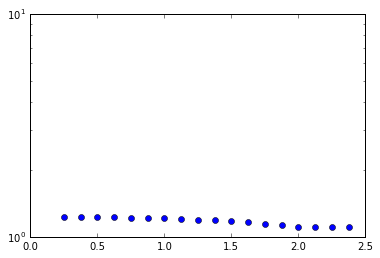

In [396]:
lvals, circ_diffs = analyze_filter_circ_diff('spherical', 1.0, 2.5)
plt.semilogy(lvals, circ_diffs, 'o')

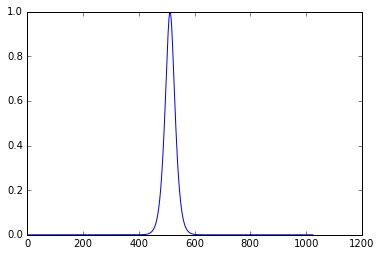

In [437]:
v = nrlib.variogram('matern52', 1.0)
L = 20
X = np.linspace(0, L, 1025)
c_list = [v.corr(L/2 - x) for x in X]
c = np.array(c_list)
plt.plot(c)

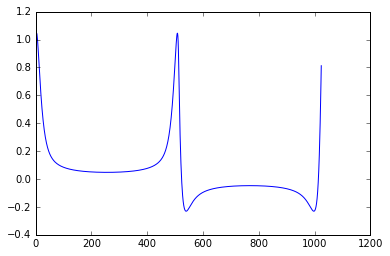

In [438]:
f = corr_to_filter(c, L, X)
plt.plot(f)

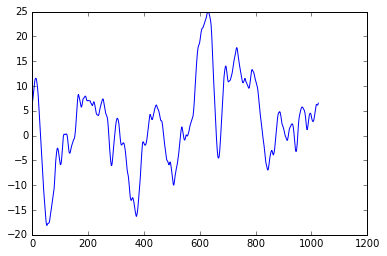

In [440]:
np.random.seed(121314)
w = np.random.normal(size=f.shape)
plt.plot(np.convolve(np.hstack((w, w)), f, 'valid'))

In [441]:
np.fft.fft(c)

array([ 46.14171455+0.j        , -45.75435023-0.14023608j,
        44.61795369+0.27350867j, ..., -42.80612456+0.39360936j,
        44.61795369-0.27350867j, -45.75435023+0.14023608j])

# Re-visiting the choice of filter

The testing above have indicated that:
- A circular continuous function $f$ is not a sufficient criteria for a proper filter
- Not having a circular continuous function could also work (i.e. it may not even be necessary), although this is surprising. It could be that if the function is "close" to circular continuous, it is not visually possible to say that it is a valid function or not
- There problem may be with the model and not the implementation

To elaborate on the last point; the calculations should be correct. However, we have not inferred any restrictions on $c$ (other than that it should be a variogram-function). When applying the FFT (or perhaps just the convolution), we are implicitly adding features to $c$ which can make it non-positive definite. If $c$ is not positive definite, this is not a well-posed problem since the corresponding covariance matrix is not SPD.

We therefore start by investigating how far from SPD the various functions are. According to Wikipedia, a function is positive definite if it is the Fourier transform of a function $g$ on the real line, with $g > 0$. (Correction: We are primarily interested in positive _semi_-definite function, which only slightly changes the above).

First, an inspection of the resulting matrix and its positive semi-definiteness.

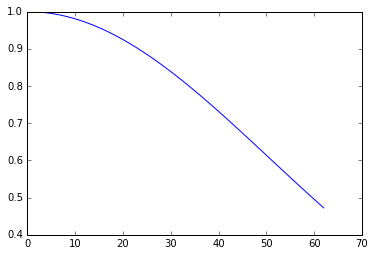

In [105]:
v = nrlib.variogram('gaussian', 1.0)
L = 1
X = np.linspace(0, L/2, 63)
c_list = [v.corr(L/2 - x) for x in X]
c = np.array(c_list)
c_flat = np.array([v.corr(x) for x in X])
plt.plot(c_flat)

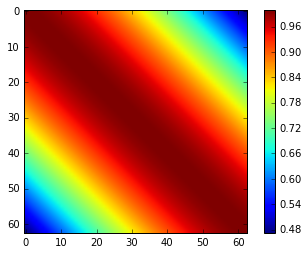

In [101]:
s_pre = np.outer(np.ones((c_flat.size,)), c_flat)

for i in range(s_pre.shape[0]):
    s_pre[i] = np.roll(s_pre[i], i)
    s_pre[i, :i] = 0
s = s_pre + s_pre.T - np.diag(np.diag(s_pre))

plt.imshow(s)
plt.colorbar()

Smallest eigvalue: -6.24318639447059e-16
Largest eigvalue : 56.11426804115789


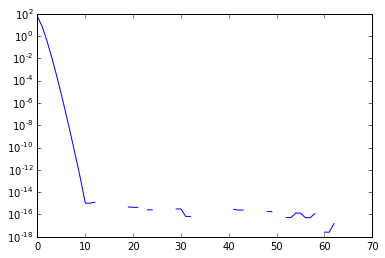

In [102]:
eigs = np.linalg.eig(s)[0]
reigs = np.real(eigs)
ieigs = np.imag(eigs)

assert np.max(np.abs(ieigs)) < 1e-14  # Just to be sure

print("Smallest eigvalue: {}".format(np.min(reigs)))
print("Largest eigvalue : {}".format(np.max(reigs)))


plt.semilogy(reigs)

Experimenting with different ranges and lengths shows that in general, longer rangest yield a less positive semi-definite matrix (when the number of 0-valued eigenvalues are a metric for positive semi-definiteness). Short ranges converge $s$ towards the identity matrix.

A conjecture that I have not found the proof of yet, although it may be trivial, is that the Fourier transform of a positive definite function is purely real and positive (?)

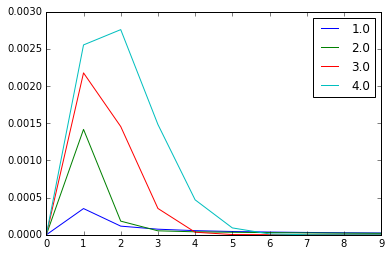

In [121]:
v = nrlib.variogram('gaussian', 1.0)
lvals = np.arange(1.0, 5.0, 1)
for L in lvals:
    X = np.linspace(0, L, 1025)
    c_list = [v.corr(L/2 - x) for x in X]
    c = np.array(c_list)
    plt.plot(np.abs(np.imag(np.fft.fft(c) * L/X.size)[:10]))
plt.legend(lvals)

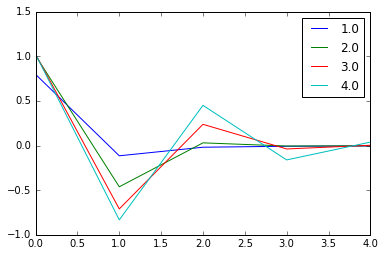

In [122]:
v = nrlib.variogram('gaussian', 1.0)
lvals = np.arange(1.0, 5.0, 1)
for L in lvals:
    X = np.linspace(0, L, 1025)
    c_list = [v.corr(L/2 - x) for x in X]
    c = np.array(c_list)
    plt.plot(np.real(np.fft.fft(c) * L/X.size)[:5])
plt.legend(lvals)

This did not prove to be very useful.

### Re-visiting the analytical solution

The current working hypothesis is that the correlation function becomes problematic when the range increases. One thing that has not been tested, though, is the analytical solution to the Gaussian variogram case for long ranges. If the working hypothesis is correct, then using the analytically found filter should also be problematic, even if regular convultion is performed.

First, verify the procedure for a short range

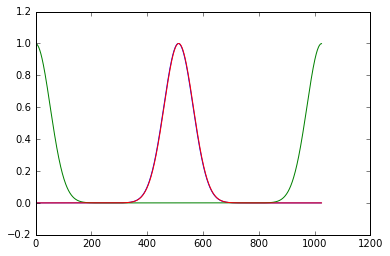

In [156]:
v = nrlib.variogram('gaussian', 1.0)
L = 8.0
X = np.linspace(0, L, 1025)
c_list = [v.corr(L/2 - x) for x in X]
# c_list = [max(v.corr(L - x), v.corr(x)) for x in X]
c = np.array(c_list)
plt.plot(c)

# Define filters
# f_analytic_L = np.sqrt(np.sqrt(12/np.pi)) * np.exp(-6 * np.square(X))
# f_analytic_R = np.sqrt(np.sqrt(12/np.pi)) * np.exp(-6 * np.square(L - X))
# f_analytic = np.max(np.array((f_analytic_L, f_analytic_R)), axis=0)
f_analytic = np.sqrt(np.sqrt(12/np.pi)) * np.exp(-6 * np.square(L/2 - X))
f_filtered = corr_to_filter(ccc=c, LLL=L, XXX=X)

# Verify analytic filter
ff_conv = L/X.size * np.convolve(
    #np.pad(f_analytic, (int(X.size/2), int(X.size/2)), mode='constant', constant_values=0.0),
    np.hstack((f_analytic, f_analytic)),
    f_analytic,
    'valid'
)
plt.plot(ff_conv)

# Verify computed filter
ff_conv2 = L/X.size * np.convolve(
    # np.pad(f_filtered, (int(X.size/2), int(X.size/2)), mode='constant', constant_values=0.0),
    np.hstack((f_filtered, f_filtered)),
    f_filtered,
    'valid'
)
plt.plot(ff_conv2)

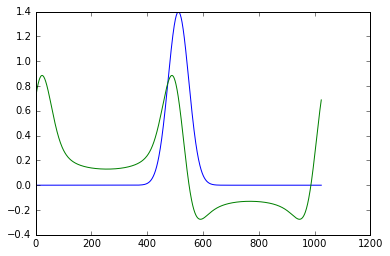

In [154]:
plt.plot(f_analytic)
plt.plot(f_filtered)

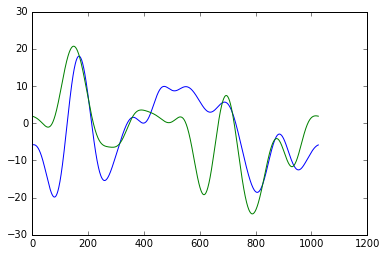

In [155]:
np.random.seed(1325252)
w = np.random.normal(size=f_analytic.shape)
z_analytic = np.convolve(np.hstack((w, w)), f_analytic, 'valid')
z_filtered = np.convolve(np.hstack((w, w)), f_filtered, 'valid')
plt.plot(z_analytic)
plt.plot(z_filtered)

Looks fine. The analytic self-convolution is shifted, but that is no problem. Now copy-and-paste all the above and re-run with a longer, known to be problematic, range.

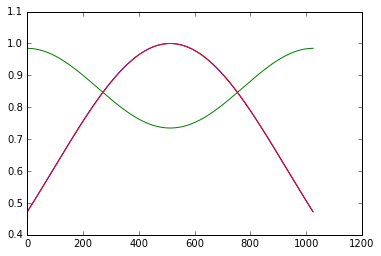

In [157]:
v = nrlib.variogram('gaussian', 1.0)
L = 1.0
X = np.linspace(0, L, 1025)
c_list = [v.corr(L/2 - x) for x in X]
# c_list = [max(v.corr(L - x), v.corr(x)) for x in X]
c = np.array(c_list)
plt.plot(c)

# Define filters
# f_analytic_L = np.sqrt(np.sqrt(12/np.pi)) * np.exp(-6 * np.square(X))
# f_analytic_R = np.sqrt(np.sqrt(12/np.pi)) * np.exp(-6 * np.square(L - X))
# f_analytic = np.max(np.array((f_analytic_L, f_analytic_R)), axis=0)
f_analytic = np.sqrt(np.sqrt(12/np.pi)) * np.exp(-6 * np.square(L/2 - X))
f_filtered = corr_to_filter(ccc=c, LLL=L, XXX=X)

# Verify analytic filter
ff_conv = L/X.size * np.convolve(
    #np.pad(f_analytic, (int(X.size/2), int(X.size/2)), mode='constant', constant_values=0.0),
    np.hstack((f_analytic, f_analytic)),
    f_analytic,
    'valid'
)
plt.plot(ff_conv)

# Verify computed filter
ff_conv2 = L/X.size * np.convolve(
    # np.pad(f_filtered, (int(X.size/2), int(X.size/2)), mode='constant', constant_values=0.0),
    np.hstack((f_filtered, f_filtered)),
    f_filtered,
    'valid'
)
plt.plot(ff_conv2)

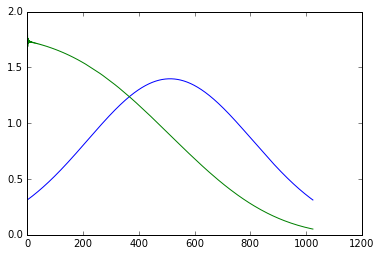

In [158]:
plt.plot(f_analytic)
plt.plot(f_filtered)

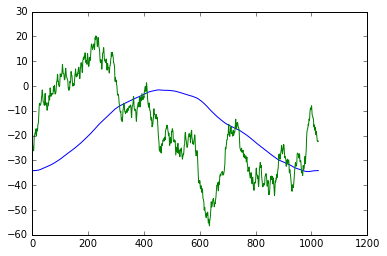

In [159]:
np.random.seed(1325252)
w = np.random.normal(size=f_analytic.shape)
z_analytic = np.convolve(np.hstack((w, w)), f_analytic, 'valid')
z_filtered = np.convolve(np.hstack((w, w)), f_filtered, 'valid')
plt.plot(z_analytic)
plt.plot(z_filtered)

The final result looks fine for the analytic solution, HOWEVER, the analytic self-convolution is not correct. 

# Summary

The primary conclusion to this notebook is that long ranges compared to grid sizes are problematic, and the problem is that the correlation function is badly conditioned/not "sufficiently" positive semi-definite in these cases. The correlation function may have a positive semi-definite form, but in the context of taking its convolution, this form is no longer the one being applied.

The path forward is to find a threshold for the range/grid-size relationship, that depends on the variogram type. This threshold will be utilized to determine the required grid size, and padding will be applied accordingly. This is to an extent exactly what is being done today, except that the current threshold is not variogram type dependent.

The threshold approach introduces another issue; computation time. If the required padding makes the grid too large for practical purposes, we have a problem. We may argue, however, that if the padded grid is too large (in number of cells), then the resolution is too high compared to the expected variation of the data, and resampling the grid before simulation and  interpolating afterwards should not alter the results too significantly, assuming a proper interpolation scheme is used.